In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
#fix the random seed
np.random.seed(42)

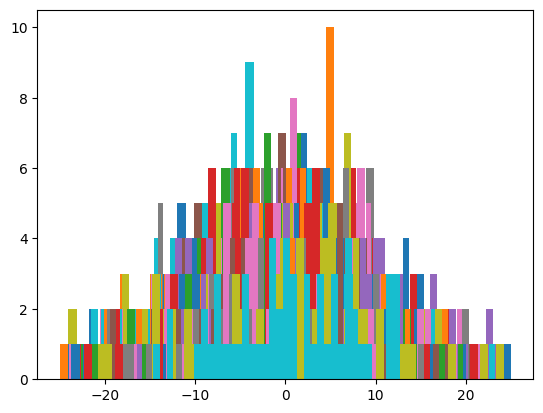

In [33]:
def generate_load_profile():
    load = np.random.randint(325, 375)  # generate a random load between 200 and 500 kW
    profile = [load]
    load_change_list = []
    for _ in range(1, 60):  # generate load for subsequent 59 minutes
        #generate a normal distributed number between -25 and 25, the numbers are not exceeded by 25
        load_change = np.random.normal(0, 7.5)
        if _ < 30:  # for the first 30 minutes, the load change is limited to 10 kW
            load_change = load_change + np.random.randint(0, 5)
        if _ > 30:
            load_change = load_change + np.random.randint(-5, 0)
        if load_change > 25:
            load_change = 25
        elif load_change < -25:
            load_change = -25
        load_change_list.append(load_change)
        load = max(200, min(500, load + load_change))  # ensure load stays within 200 and 500 kW range
        profile.append(load)
    
    plt.hist(load_change_list, bins=50)
    return profile

# Generate 200 load profiles
load_profiles = [generate_load_profile() for _ in range(200)]

# Split the profiles into in-sample (50 profiles) and out-of-sample (150 profiles)
in_sample_profiles = load_profiles[:50]
out_of_sample_profiles = load_profiles[50:]

# Now, you can use in_sample_profiles for in-sample decision making and out_of_sample_profiles for out-of-sample analysis.
load_profiles = pd.DataFrame(load_profiles).T
load_profiles.to_csv('load_profiles.csv', index=False)

In [34]:
load_profiles.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,363.000000,369.000000,332.000000,369.000000,368.000000,356.000000,329.000000,346.000000,364.000000,337.000000,...,342.000000,329.000000,355.000000,340.000000,365.000000,326.000000,356.000000,349.000000,367.000000,334.000000
1,362.873241,371.706925,341.070365,372.076748,372.342059,350.055899,331.783594,352.221548,372.183115,336.395084,...,358.289949,337.597283,362.674456,345.911612,365.407968,326.185559,349.522184,341.501936,361.274823,334.534943
2,370.738989,373.917497,348.105065,377.335011,379.260906,357.564245,328.253705,353.204883,373.248512,349.148356,...,357.637161,339.877296,362.138566,337.317552,358.602924,334.242442,356.276480,342.051511,350.405940,326.815562
3,370.982839,369.752398,357.480969,378.446374,383.813111,358.677228,335.914036,348.905938,376.290793,362.306670,...,353.596603,340.667920,357.521930,346.630855,367.963646,342.695477,355.983505,347.586193,355.976934,313.904225
4,371.226812,377.972208,364.438519,384.026885,384.220740,364.298028,349.765041,348.568584,380.454383,361.345083,...,359.787867,331.430472,347.582321,342.438737,357.910959,342.898019,360.633685,359.927428,368.767464,312.231061


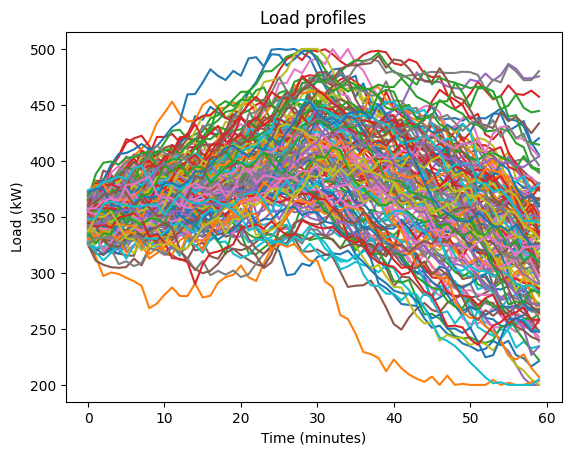

In [35]:
# Plot the first 5 load profiles
for i in range(150):
    plt.plot(load_profiles.index, load_profiles[i], label=f'Profile {i+1}')
plt.xlabel('Time (minutes)')
plt.ylabel('Load (kW)')
plt.title('Load profiles')
plt.show()

In [76]:
# Read the load profiles from the CSV file
load_profiles = pd.read_csv('load_profiles.csv')

n_in_sample = 50
#select first 50 columns
in_sample_profiles = load_profiles.iloc[:, :n_in_sample]
out_of_sample_profiles = load_profiles.iloc[:, n_in_sample:]
counter = np.arange(200, 501, 1)

In [77]:
def get_histogram(data):

    selfmade_df = pd.DataFrame(counter, columns=['load'])

    for minute in range(60):
        #make list with zeros and length of counter
        column_list = np.zeros(len(counter))
        for step in range(len(column_list)):
            for i in range(data.shape[1]):
                if data.iloc[minute, i] >= counter[step]:
                    column_list[step] += 1
        selfmade_df[minute] = column_list
    
    selfmade_df = selfmade_df.set_index('load')
    selfmade_df = selfmade_df/selfmade_df.max()
    return selfmade_df


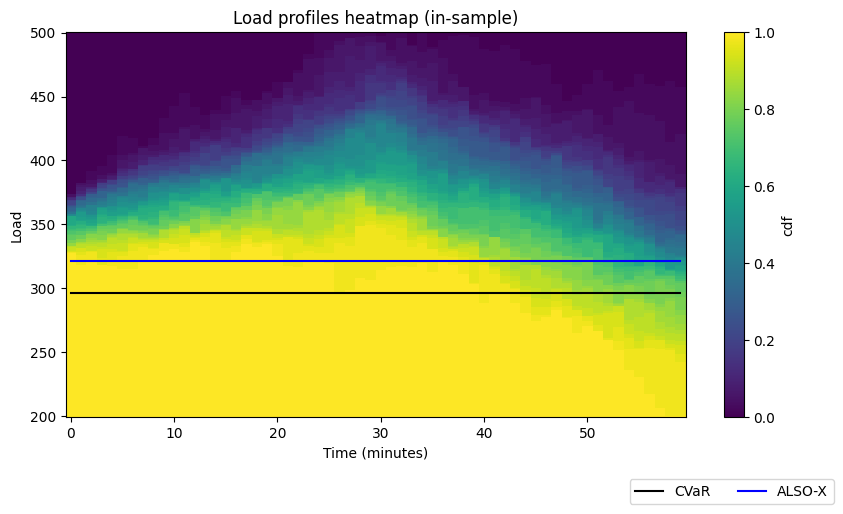

In [78]:
in_sample_hist_df = get_histogram(in_sample_profiles)

# make data with uneven sampling in x
x = range(0, 60, 1)
X, Y = np.meshgrid(x, counter)
Z = in_sample_hist_df.values
# plot
fig, ax = plt.subplots(figsize=(10, 5))

c = ax.pcolormesh(X, Y, Z, vmin=0, vmax=1.0)
plt.xlabel('Time (minutes)')
plt.ylabel('Load')
plt.title('Load profiles heatmap (in-sample)')
Also_X = 321.7965945853627
C_Var = 296.4980071934071
#make vector of 291 value vector
cvar_value = np.linspace(C_Var, C_Var, 60)
alsox_value = np.linspace(Also_X, Also_X, 60)

#plt.plot(x, mean_load, color='red')
plt.plot(x, cvar_value , color='black', label='CVaR')
plt.plot(x, alsox_value , color='blue', label='ALSO-X')
fig.legend(bbox_to_anchor=(0.9, 0.0), ncols=3)

fig.colorbar(c, ax=ax, label='cdf')

plt.show()

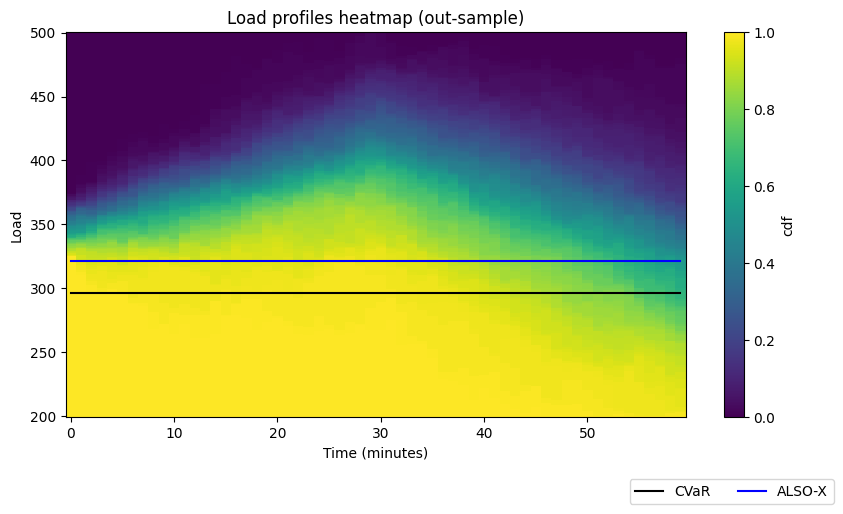

In [79]:
out_sample_hist_df = get_histogram(out_of_sample_profiles)

# make data with uneven sampling in x
x = range(0, 60, 1)
X, Y = np.meshgrid(x, counter)
Z = out_sample_hist_df.values
# plot
fig, ax = plt.subplots(figsize=(10, 5))

c = ax.pcolormesh(X, Y, Z, vmin=0, vmax=1.0)
plt.xlabel('Time (minutes)')
plt.ylabel('Load')
plt.title('Load profiles heatmap (out-sample)')
Also_X = 321.7965945853627
C_Var = 296.4980071934071
#make vector of 291 value vector
cvar_value = np.linspace(C_Var, C_Var, 60)
alsox_value = np.linspace(Also_X, Also_X, 60)

#plt.plot(x, mean_load, color='red')
plt.plot(x, cvar_value , color='black', label='CVaR')
plt.plot(x, alsox_value , color='blue', label='ALSO-X')
fig.legend(bbox_to_anchor=(0.9, 0.0), ncols=3)

fig.colorbar(c, ax=ax, label='cdf')

plt.show()